In [1]:
# Cell 1 - Imports & settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

sns.set(style="whitegrid")

In [2]:
# Cell 2 - Load dataset
# Downloaded CSV should be in the same folder, e.g. 'Churn_Modelling.csv'
df = pd.read_csv('Churn_Modelling.csv')
print("Shape:", df.shape)
df.head()

Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

Target distribution (Exited):
 Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float6

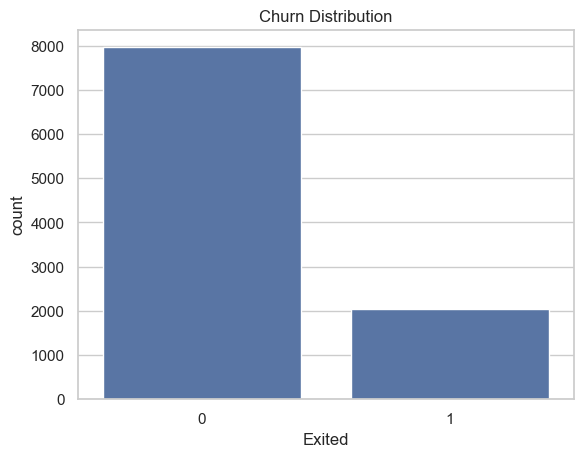

In [3]:
# Cell 3 - EDA
df.info()
df.describe().T
print("\nTarget distribution (Exited):\n", df['Exited'].value_counts(normalize=True))
sns.countplot(x='Exited', data=df)
plt.title('Churn Distribution')
plt.show()


In [4]:
# Cell 4 - Features & target
# Drop identifier-like columns that do not help learning
drop_cols = ['RowNumber','CustomerId','Surname']  # present in this dataset
df = df.drop(columns=drop_cols, errors='ignore')

# Target
y = df['Exited']
X = df.drop(columns=['Exited'])

print("Feature columns:", X.columns.tolist())
print("X shape:", X.shape, "y shape:", y.shape)

Feature columns: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
X shape: (10000, 10) y shape: (10000,)


In [5]:
# Cell 5 - Preprocessing: encoding and split
# One-hot encode Geography; convert Gender to binary
X = X.copy()
if 'Geography' in X.columns:
    X = pd.get_dummies(X, columns=['Geography'], drop_first=True)
if 'Gender' in X.columns:
    X['Gender'] = X['Gender'].map({'Female':0, 'Male':1})

# Train-test split (stratify to preserve churn ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (8000, 11) Test: (2000, 11)


In [10]:
# --- FIXED NORMALIZATION CELL ---
from sklearn.preprocessing import StandardScaler

# Convert bool columns to int (0/1)
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols]  = X_test[bool_cols].astype(int)

# Convert all columns to numeric (safety)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test  = X_test.apply(pd.to_numeric, errors='coerce')

# Fill any NaN with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Normalize numeric columns
numeric_cols = X_train.columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled  = scaler.transform(X_test[numeric_cols])

# Convert to float32 numpy arrays for TensorFlow
X_train_np = X_train_scaled.astype('float32')
X_test_np  = X_test_scaled.astype('float32')
y_train_np = y_train.astype('float32').values
y_test_np  = y_test.astype('float32').values

print("✅ Shapes:", X_train_np.shape, X_test_np.shape)
print("✅ Dtypes:", X_train_np.dtype, y_train_np.dtype)

✅ Shapes: (8000, 11) (2000, 11)
✅ Dtypes: float32 float32


In [7]:
# Cell 7 - Baseline NN model
input_dim = X_train_np.shape[1]

def build_baseline_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

baseline_model = build_baseline_model(input_dim)
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Debug cell
print(X_train.dtypes)
print("\nNon-numeric columns:", X_train.select_dtypes(exclude=[np.number]).columns.tolist())

CreditScore            int64
Gender                 int64
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Geography_Germany      int32
Geography_Spain        int32
dtype: object

Non-numeric columns: []


In [12]:
history = baseline_model.fit(
    X_train_np, y_train_np,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5286 - loss: 0.6960 - val_accuracy: 0.8067 - val_loss: 0.4658
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7962 - loss: 0.4656 - val_accuracy: 0.8275 - val_loss: 0.4152
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8226 - loss: 0.4274 - val_accuracy: 0.8425 - val_loss: 0.3958
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8288 - loss: 0.4089 - val_accuracy: 0.8533 - val_loss: 0.3756
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8373 - loss: 0.3911 - val_accuracy: 0.8525 - val_loss: 0.3597
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8454 - loss: 0.3769 - val_accuracy: 0.8592 - val_loss: 0.3477
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8474 - loss: 0.3669 - val_accuracy: 0.8608 - val_loss: 0.3394
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8492 - loss: 0.3603 - val_accu

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Baseline Accuracy: 0.86

Confusion Matrix:
 [[1531   62]
 [ 218  189]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.96      0.92      1593
         1.0       0.75      0.46      0.57       407

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000



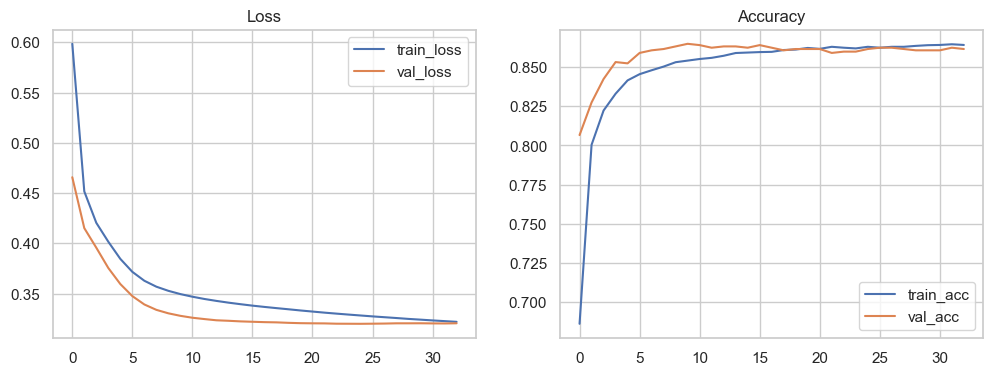

In [13]:
# Cell 9 - Evaluate baseline
y_pred_prob = baseline_model.predict(X_test_np).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_test_np, y_pred)
cm = confusion_matrix(y_test_np, y_pred)
print("Baseline Accuracy:", acc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test_np, y_pred))

# plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [14]:
# Cell 10 - Improved model builder
from tensorflow.keras import regularizers

def build_improved_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

improved_model = build_improved_model(input_dim)
improved_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 192 (768.00 B)

In [15]:
# Cell 11 - Train improved model
# compute class weights if needed
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Callbacks
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history_imp = improved_model.fit(
    X_train_np, y_train_np,
    validation_split=0.15,
    epochs=150,
    batch_size=64,
    callbacks=[es, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

Class weights: {0: 0.6279434850863422, 1: 2.4539877300613497}
Epoch 1/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5623 - loss: 0.7338 - val_accuracy: 0.7642 - val_loss: 0.5808 - learning_rate: 0.0010
Epoch 2/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6669 - loss: 0.6046 - val_accuracy: 0.7625 - val_loss: 0.5150 - learning_rate: 0.0010
Epoch 3/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6947 - loss: 0.5624 - val_accuracy: 0.7692 - val_loss: 0.4796 - learning_rate: 0.0010
Epoch 4/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7075 - loss: 0.5551 - val_accuracy: 0.7667 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 5/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7261 - loss: 0.5331 - val_accuracy: 0.7783 - val_loss: 0.4591 - learning_rate: 0.0010
Epoch 6/150
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7330 - loss: 0.5250 - val_accuracy: 0.7892 - val_loss: 0.4482 - learning_rate: 0.0010
Epoch 7/150
107/107 

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Improved Model Accuracy: 0.7995

Confusion Matrix:
 [[1294  299]
 [ 102  305]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.81      0.87      1593
         1.0       0.50      0.75      0.60       407

    accuracy                           0.80      2000
   macro avg       0.72      0.78      0.73      2000
weighted avg       0.84      0.80      0.81      2000

ROC-AUC: 0.8563787207855006


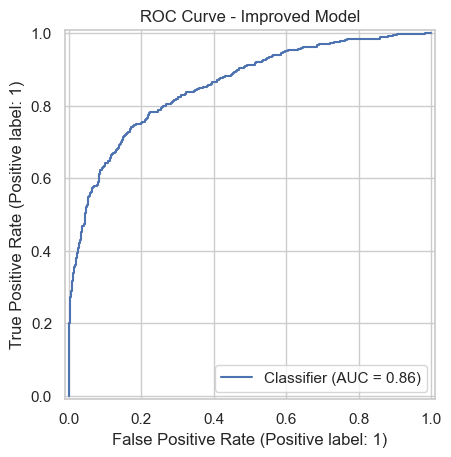

In [16]:
# Cell 12 - Evaluate improved model
y_pred_prob_imp = improved_model.predict(X_test_np).ravel()
y_pred_imp = (y_pred_prob_imp >= 0.5).astype(int)

acc_imp = accuracy_score(y_test_np, y_pred_imp)
cm_imp = confusion_matrix(y_test_np, y_pred_imp)

print("Improved Model Accuracy:", acc_imp)
print("\nConfusion Matrix:\n", cm_imp)
print("\nClassification Report:\n", classification_report(y_test_np, y_pred_imp))

# Plot ROC-AUC if desired
from sklearn.metrics import roc_auc_score, RocCurveDisplay
roc_auc = roc_auc_score(y_test_np, y_pred_prob_imp)
print("ROC-AUC:", roc_auc)
RocCurveDisplay.from_predictions(y_test_np, y_pred_prob_imp)
plt.title('ROC Curve - Improved Model')
plt.show()